#### This repo is based on the paper `A Neural Probabilistic Language Model` Bengio et. al

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [5]:
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
chars = sorted(list(set(''.join(words)))) # getting the list of all unique characters in the dataset in sorted order(a-z)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


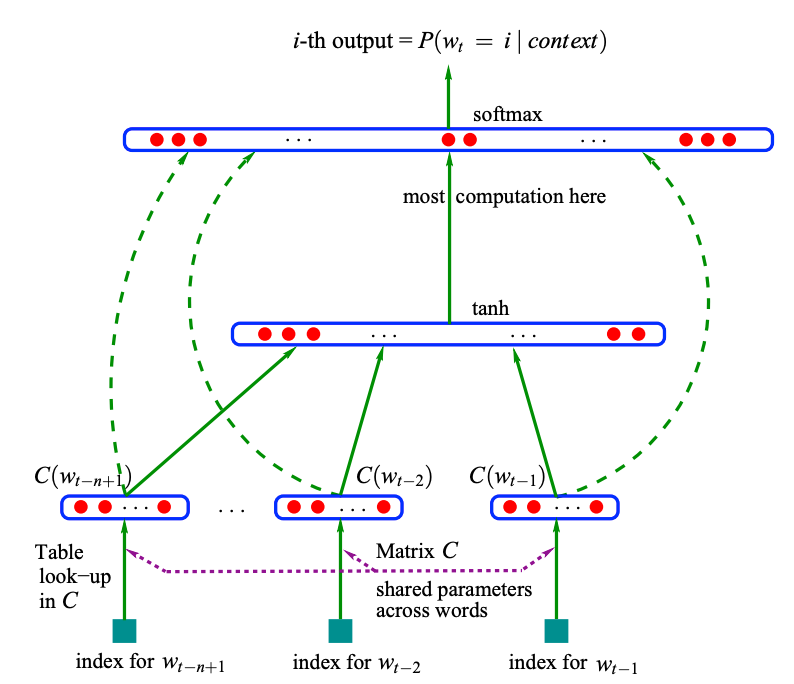

In [158]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [159]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [12]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

Creating Embeddings, in the paper 17,000 words are represented as 30 dimensional vector. We have 27 chars lets start by making a 2 dim space to represent these vectors

In [72]:
C = torch.randn((27,2))

In [73]:
C

tensor([[-0.2851,  0.5575],
        [-0.3284,  0.1866],
        [ 0.2962,  0.1741],
        [-0.0616,  0.4991],
        [ 0.8855,  0.8242],
        [ 0.4331, -1.1127],
        [ 1.1298,  0.2788],
        [ 1.0713,  0.1985],
        [ 0.1065, -1.0435],
        [ 1.7115, -1.1631],
        [-1.0408, -0.4242],
        [ 1.6528,  1.4102],
        [-0.9577, -1.4005],
        [-0.4015, -0.9808],
        [-0.0256,  1.9487],
        [-1.6952, -0.4400],
        [-0.7391,  0.9601],
        [-0.3334, -0.6848],
        [-0.0661,  0.0663],
        [ 0.9878, -0.1222],
        [-0.4335,  0.0115],
        [-0.0649,  0.7117],
        [ 0.7023, -1.5780],
        [ 0.4593,  0.2261],
        [-0.1475, -1.9741],
        [ 0.4060, -0.6547],
        [-0.4133,  0.3234]])

In [74]:
# lets say that we want the embedding of the 5 
C[5]

tensor([ 0.4331, -1.1127])

In [75]:
# other way would be to convert 5 to one hot encoding and then use matrix multiplication
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.4331, -1.1127])

In [76]:
# we will use the indexing method instead of one-hot encoding as it is much faster
# torch indexing is flexible
C[[5,7,8]]

tensor([[ 0.4331, -1.1127],
        [ 1.0713,  0.1985],
        [ 0.1065, -1.0435]])

In [77]:
C[torch.tensor([5,5,6,6,3,3,3])]

tensor([[ 0.4331, -1.1127],
        [ 0.4331, -1.1127],
        [ 1.1298,  0.2788],
        [ 1.1298,  0.2788],
        [-0.0616,  0.4991],
        [-0.0616,  0.4991],
        [-0.0616,  0.4991]])

In [78]:
C[X]

tensor([[[-0.2851,  0.5575],
         [-0.2851,  0.5575],
         [-0.2851,  0.5575]],

        [[-0.2851,  0.5575],
         [-0.2851,  0.5575],
         [ 0.4331, -1.1127]],

        [[-0.2851,  0.5575],
         [ 0.4331, -1.1127],
         [-0.4015, -0.9808]],

        [[ 0.4331, -1.1127],
         [-0.4015, -0.9808],
         [-0.4015, -0.9808]],

        [[-0.4015, -0.9808],
         [-0.4015, -0.9808],
         [-0.3284,  0.1866]],

        [[-0.2851,  0.5575],
         [-0.2851,  0.5575],
         [-0.2851,  0.5575]],

        [[-0.2851,  0.5575],
         [-0.2851,  0.5575],
         [-1.6952, -0.4400]],

        [[-0.2851,  0.5575],
         [-1.6952, -0.4400],
         [-0.9577, -1.4005]],

        [[-1.6952, -0.4400],
         [-0.9577, -1.4005],
         [ 1.7115, -1.1631]],

        [[-0.9577, -1.4005],
         [ 1.7115, -1.1631],
         [ 0.7023, -1.5780]],

        [[ 1.7115, -1.1631],
         [ 0.7023, -1.5780],
         [ 1.7115, -1.1631]],

        [[ 0.7023, -1

In [79]:
C[X].shape

torch.Size([32, 3, 2])

In [80]:
emd = C[X]
emd.shape

torch.Size([32, 3, 2])

#### Implementing Second Layer (Hidden Layer) of the Neural Net

In [81]:
# input to next layer is 2 (dim of emd) * 3 (no of chars) = 6
# number of neurons in the layer is a hyperparameter
W1 = torch.rand((6,100))
b1 = torch.rand((100))

In [82]:
emd @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [83]:
# this cannot be directly multipled and we need to concatanate (32,3,2) into (32,6)
torch.cat((emd[:,0,:], emd[:,1,:], emd[:,2,:]), dim=1).shape # indexing like this is not feasible if we want to change the block size

torch.Size([32, 6])

In [84]:
# we can use torch.unbind that given the index of the dim, removes that tensor dimension (https://pytorch.org/docs/main/generated/torch.unbind.html#torch-unbind)
len(torch.unbind(emd, 1))

3

In [85]:
torch.cat(torch.unbind(emd,1), 1).shape

torch.Size([32, 6])

#### More efficient usage of Torch using [PyTorch internals](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [86]:
# there is a more efficient way of doing this using torch.view
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [87]:
a.shape

torch.Size([18])

In [88]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [89]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [90]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.LongStorage of size 18]

In [91]:
emd.shape

torch.Size([32, 3, 2])

In [92]:
emd.view(32,6)

tensor([[-0.2851,  0.5575, -0.2851,  0.5575, -0.2851,  0.5575],
        [-0.2851,  0.5575, -0.2851,  0.5575,  0.4331, -1.1127],
        [-0.2851,  0.5575,  0.4331, -1.1127, -0.4015, -0.9808],
        [ 0.4331, -1.1127, -0.4015, -0.9808, -0.4015, -0.9808],
        [-0.4015, -0.9808, -0.4015, -0.9808, -0.3284,  0.1866],
        [-0.2851,  0.5575, -0.2851,  0.5575, -0.2851,  0.5575],
        [-0.2851,  0.5575, -0.2851,  0.5575, -1.6952, -0.4400],
        [-0.2851,  0.5575, -1.6952, -0.4400, -0.9577, -1.4005],
        [-1.6952, -0.4400, -0.9577, -1.4005,  1.7115, -1.1631],
        [-0.9577, -1.4005,  1.7115, -1.1631,  0.7023, -1.5780],
        [ 1.7115, -1.1631,  0.7023, -1.5780,  1.7115, -1.1631],
        [ 0.7023, -1.5780,  1.7115, -1.1631, -0.3284,  0.1866],
        [-0.2851,  0.5575, -0.2851,  0.5575, -0.2851,  0.5575],
        [-0.2851,  0.5575, -0.2851,  0.5575, -0.3284,  0.1866],
        [-0.2851,  0.5575, -0.3284,  0.1866,  0.7023, -1.5780],
        [-0.3284,  0.1866,  0.7023, -1.5

In [93]:
emd.view(32,6) == torch.cat(torch.unbind(emd,1), 1) # torch.cat(torch.unbind(emd,1), 1) is not efficient as torch.cat creates a new memory and view directly manipulates the storage

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [94]:
# h = emd.view(emd.shape[0],6) @ W1 + b1
# h = emd.view(32,6) @ W1 + b1
h = emd.view(-1,6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [96]:
h = torch.tanh(emd.view(-1,6) @ W1 + b1)
h

tensor([[-0.3009,  0.8770,  0.5154,  ...,  0.6234,  0.7410,  0.4528],
        [-0.0635,  0.1850,  0.1639,  ...,  0.2303, -0.1716,  0.2014],
        [-0.1064, -0.5934,  0.4776,  ..., -0.4231,  0.0767, -0.7834],
        ...,
        [-0.9762, -0.5960, -0.7569,  ..., -0.4405, -0.9126, -0.6733],
        [ 0.7124, -0.2350,  0.2580,  ...,  0.6031, -0.2437, -0.4777],
        [ 0.8478, -0.6508,  0.9572,  ...,  0.5081,  0.8467,  0.0027]])

torch.Size([32, 100])

#### Implementing Third Layer (Softmax) of the Neural Net

In [101]:
W2 = torch.randn((100,27)) # input from last layer 100 and output is 27 different characters
b2 = torch.rand((27))

In [102]:
logits = h @ W2 + b2

In [103]:
logits.shape

torch.Size([32, 27])

In [104]:
counts = logits.exp()

In [106]:
prob = counts / counts.sum(1, keepdim=True)

In [108]:
prob.shape

torch.Size([32, 27])

In [110]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [111]:
prob[torch.arange(32), Y]

tensor([1.1670e-04, 5.3432e-06, 9.9929e-06, 1.2572e-08, 1.2959e-09, 2.1045e-04,
        8.8950e-01, 5.9011e-12, 1.4179e-08, 1.1679e-12, 7.7991e-10, 1.1980e-09,
        6.8916e-03, 5.3618e-02, 2.9865e-06, 1.0327e-10, 4.4290e-01, 2.0789e-12,
        1.2404e-06, 1.0462e-04, 6.1076e-03, 2.3923e-05, 3.2438e-01, 1.4854e-08,
        7.2995e-11, 1.0362e-08, 2.7521e-07, 1.0365e-06, 2.3733e-03, 7.3033e-13,
        1.2567e-04, 4.6284e-10])

In [112]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.2790)

#### Complete formulation

In [160]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [161]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C,W1,b1,W2,b2]

In [162]:
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}") # number of parameters

Number of parameters: 3481


In [163]:
emd = C[X] # (32, 3, 2)
h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(17.7697)

In [126]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32),Y].log().mean()
# loss
# this is also known as classfication and torch already has a Cross Entropy Function that efficiently implements this idea

In [127]:
emd = C[X] # (32, 3, 2)
h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

We use F.cross_entropy not just because of efficient implementation but also the guardrails it provides in case of inf vals

In [131]:
# if my logits are as follows:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
prob = counts / counts.sum()
print(f"Probs: {prob}")
print(f"Counts: {counts}")

Probs: tensor([0., 0., 0., nan])
Counts: tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])


we recieve a `nan` in probs because the e^(100) = `inf` therefore we get a `nan` value at the last index
Pytorch solves this problem by adding (subtracting) an offset that is equal to the max in the tensor, the result is unaltered   

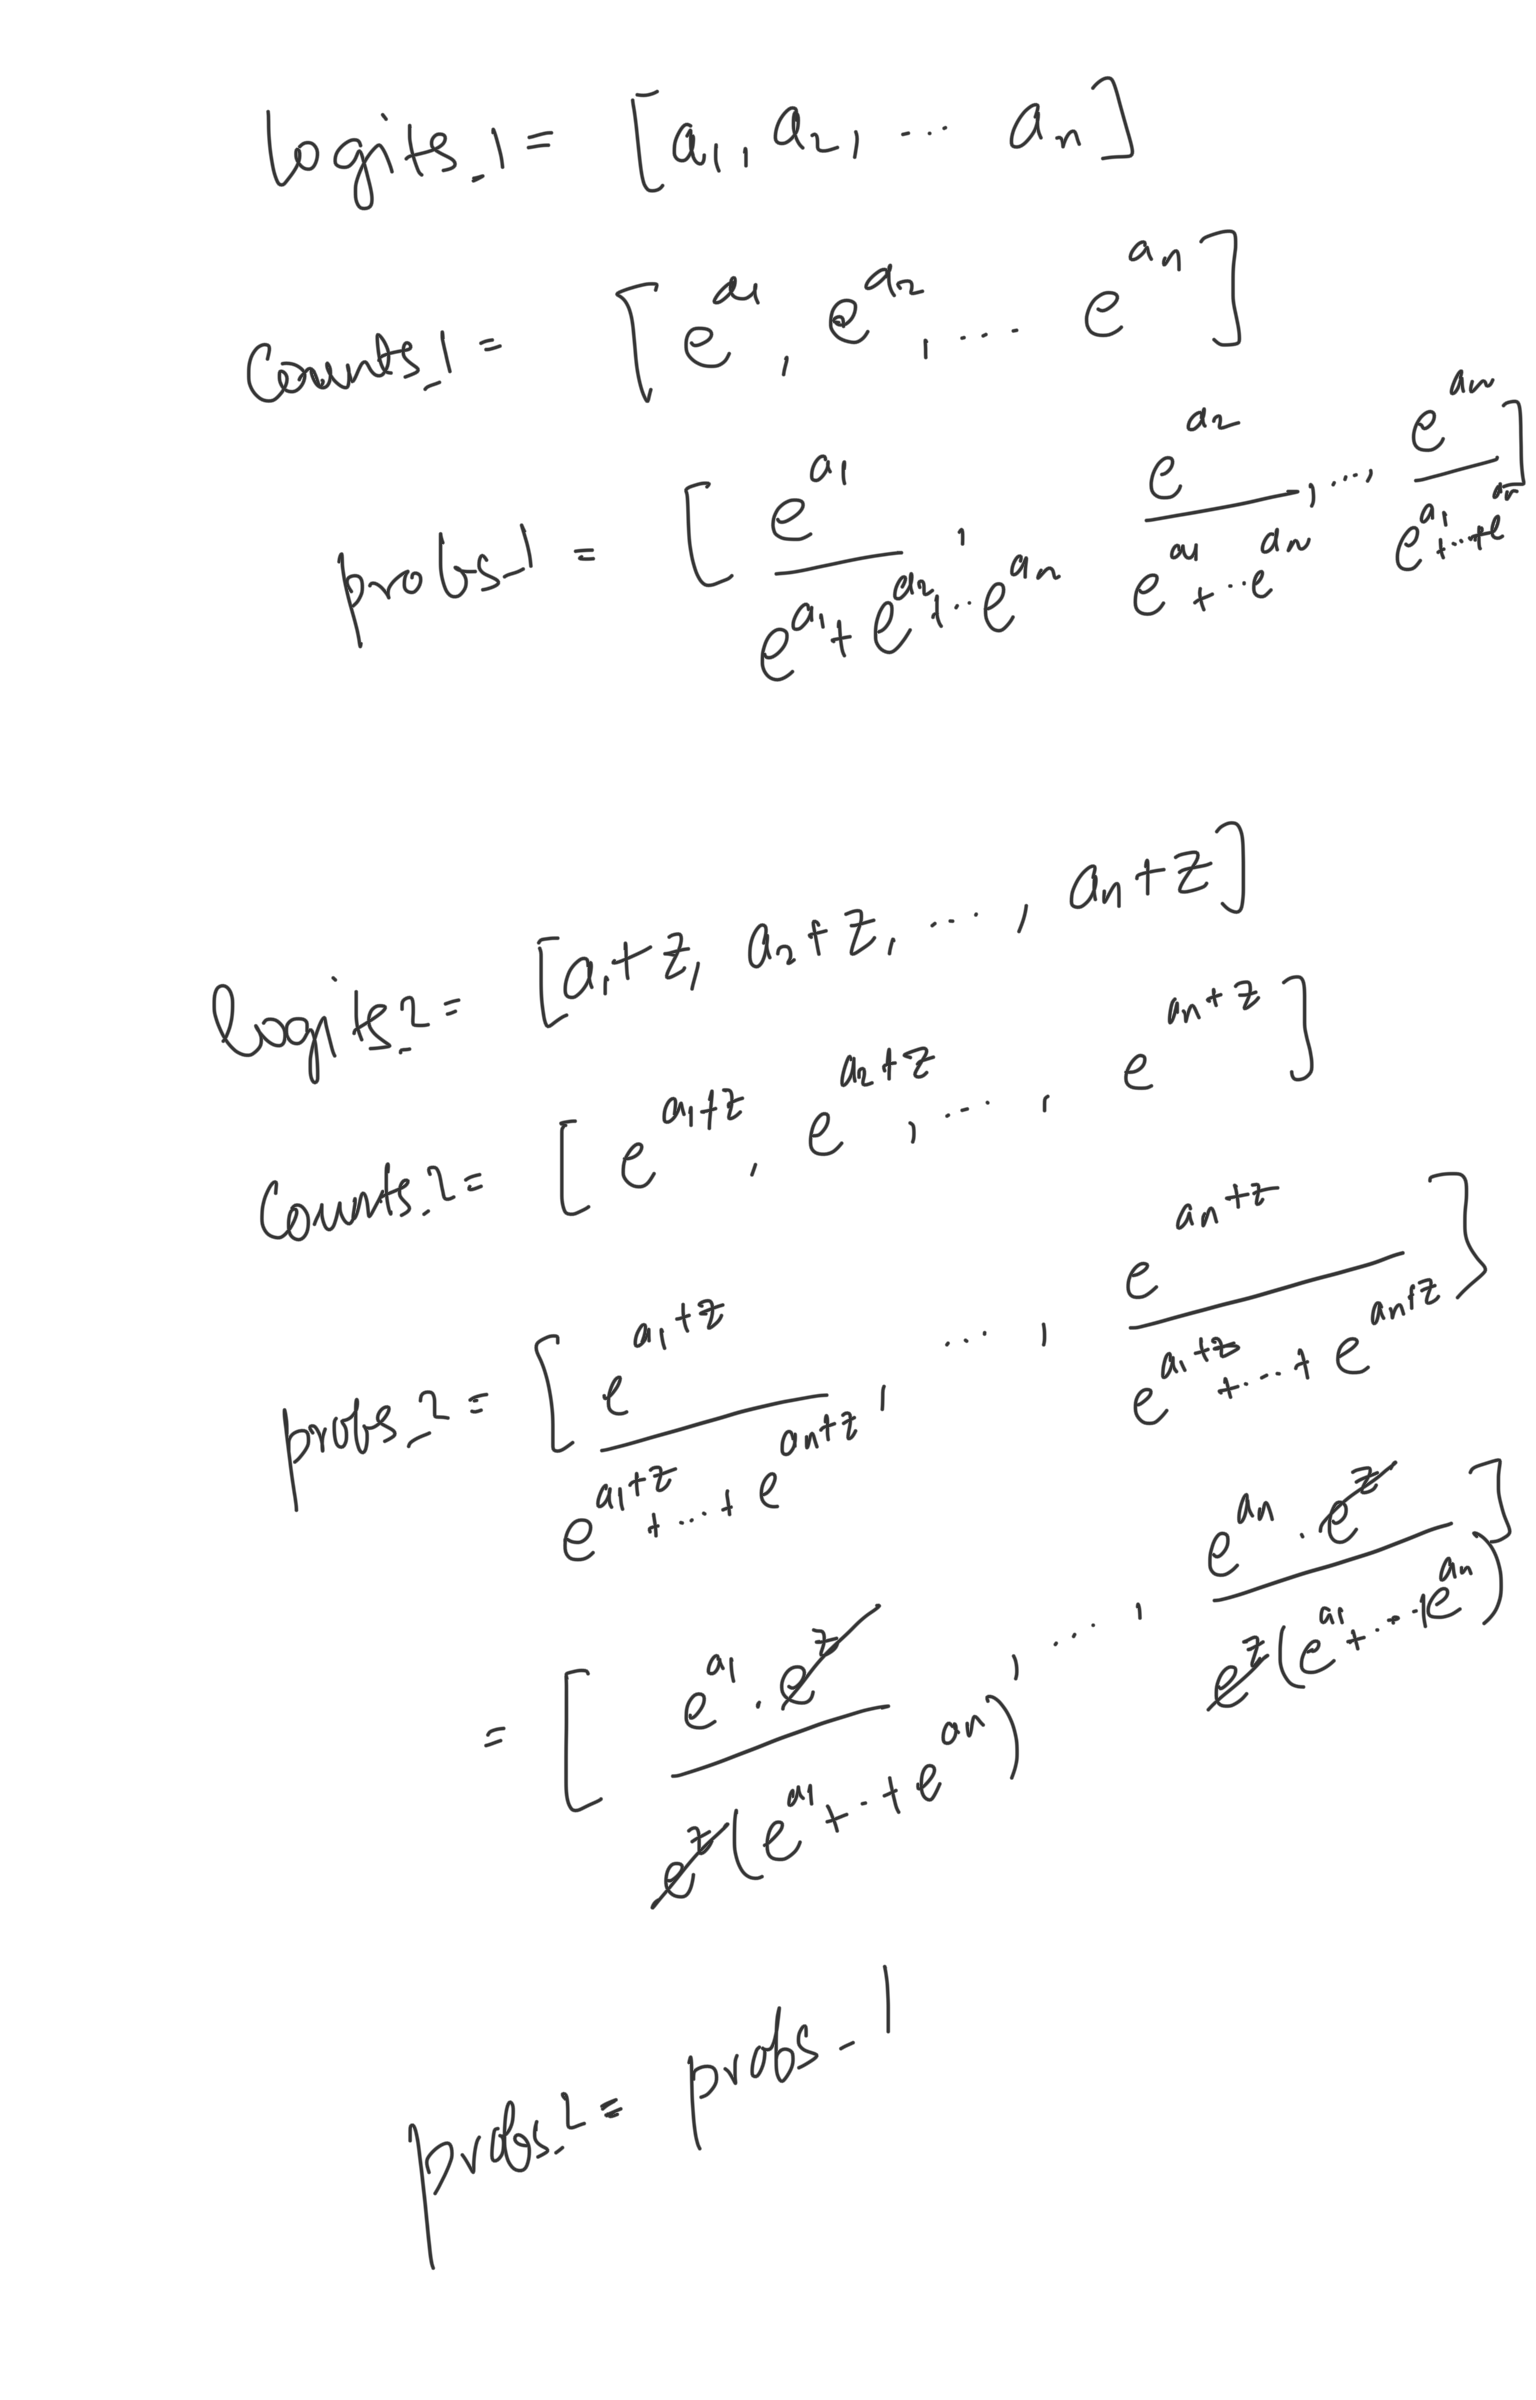

In [142]:
from IPython.display import Image
PATH = "../"
Image(filename = PATH + "proof.PNG", width=500, height=500)

In [138]:
logits = torch.tensor([-5, -3, 0, 5])
counts = logits.exp()
prob = counts / counts.sum()
print(f"Probs: {prob}")
print(f"Counts: {counts}")

Probs: tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])
Counts: tensor([6.7379e-03, 4.9787e-02, 1.0000e+00, 1.4841e+02])


In [139]:
logits = torch.tensor([-5, -3, 0, 5]) - 5
counts = logits.exp()
prob = counts / counts.sum()
print(f"Probs: {prob}")
print(f"Counts: {counts}")

Probs: tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])
Counts: tensor([4.5400e-05, 3.3546e-04, 6.7379e-03, 1.0000e+00])


In [164]:
for p in parameters:
    p.requires_grad = True

In [165]:
import time

In [166]:
start_time = time.time()
for _ in range(30):    
    # forward pass
    emd = C[X] # (32, 3, 2)
    h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(f"Loss: {loss}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimize
    for p in parameters:
        p.data += -0.1 * p.grad

end_time = time.time()
print(f"total time taken: {end_time - start_time :.4f}")

Loss: 17.76971435546875
Loss: 13.656403541564941
Loss: 11.298772811889648
Loss: 9.452458381652832
Loss: 7.984263896942139
Loss: 6.891322135925293
Loss: 6.100015640258789
Loss: 5.452036380767822
Loss: 4.8981523513793945
Loss: 4.4146647453308105
Loss: 3.985849618911743
Loss: 3.602830648422241
Loss: 3.262141704559326
Loss: 2.961381435394287
Loss: 2.6982975006103516
Loss: 2.469712972640991
Loss: 2.271660804748535
Loss: 2.101283550262451
Loss: 1.9571771621704102
Loss: 1.837485909461975
Loss: 1.7380971908569336
Loss: 1.6535120010375977
Loss: 1.5790897607803345
Loss: 1.5117669105529785
Loss: 1.449605107307434
Loss: 1.3913124799728394
Loss: 1.335992455482483
Loss: 1.2830536365509033
Loss: 1.232192039489746
Loss: 1.183382511138916
total time taken: 0.0414


In [167]:
logits.max(1)

torch.return_types.max(
values=tensor([10.5282, 10.1852, 17.0632, 13.6134,  9.7702, 10.5282, 10.4055,  9.9263,
        12.7258, 14.2854, 10.3205, 16.1669, 10.5282, 11.0111, 11.4442, 13.5975,
        10.5282, 11.7459,  9.2716, 11.0190, 14.6786, 11.2179,  6.9765,  7.5228,
        13.1394, 10.5282, 10.9369, 11.9717, 10.0946, 13.4636, 13.0579, 10.3513],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 12, 13,  1,  0,  1, 13,  9, 22,  9,  1,  0,  1,  0,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  9,  0,  1, 15, 16,  8,  9,  1,  0]))

In [168]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

the loss is extremely low because the model is overfitting, this is because we only have 32 examples but we have 3481 parameters. the loss however is not zero because many examples are not unique, lets say predicting the first character based on `..` which in the training set is either of `e`, `o`, `a`, `i`, or `s`

#### Building Model for the entire dataset

In [169]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [170]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [171]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C,W1,b1,W2,b2]

In [172]:
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}") # number of parameters

Number of parameters: 3481


In [173]:
for p in parameters:
    p.requires_grad = True

In [174]:
start_time = time.time()
for _ in range(30):    
    # forward pass
    emd = C[X] # (32, 3, 2)
    h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(f"Loss: {loss}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimize
    for p in parameters:
        p.data += -0.1 * p.grad

end_time = time.time()
print(f"total time taken: {end_time - start_time :.4f}")

Loss: 19.505229949951172
Loss: 17.084491729736328
Loss: 15.776532173156738
Loss: 14.83333683013916
Loss: 14.002595901489258
Loss: 13.253254890441895
Loss: 12.579914093017578
Loss: 11.983097076416016
Loss: 11.470491409301758
Loss: 11.05185604095459
Loss: 10.709586143493652
Loss: 10.407632827758789
Loss: 10.127808570861816
Loss: 9.86436653137207
Loss: 9.61450481414795
Loss: 9.37644100189209
Loss: 9.148946762084961
Loss: 8.931112289428711
Loss: 8.722232818603516
Loss: 8.52175235748291
Loss: 8.329231262207031
Loss: 8.144329071044922
Loss: 7.966794967651367
Loss: 7.796453952789307
Loss: 7.633190155029297
Loss: 7.476912975311279
Loss: 7.327526092529297
Loss: 7.184889793395996
Loss: 7.048796653747559
Loss: 6.918957233428955
total time taken: 17.4407


As we can see the time taken for the 30 epochs in this case is significantly higher 0.04 secs vs 17 secs. This is because the forward pass and backward pass is being calculated for each of 28k+ training examples. In order to solve this problem we can use mini-batches

In [177]:
torch.randint(0,X.shape[0],(32,))

tensor([158009,  81806,  30084, 125408, 119946,  92385,  34192,  99058, 227820,
        116871, 191711, 158683,  44267, 163322,  94268, 106680, 149568,  39783,
         75332, 166605,  23026, 103453,  93343, 177602,  10557,   3899,  40004,
        107349,   1701, 115288,  70207,  66870])

In [175]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True

In [178]:
start_time = time.time()
for _ in range(30):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))    
    # forward pass
    emd = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Loss: {loss}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimize
    for p in parameters:
        p.data += -0.1 * p.grad

end_time = time.time()
print(f"total time taken: {end_time - start_time :.4f}")

Loss: 19.132490158081055
Loss: 13.845993995666504
Loss: 17.099834442138672
Loss: 12.663110733032227
Loss: 14.215557098388672
Loss: 14.338127136230469
Loss: 12.401246070861816
Loss: 10.688631057739258
Loss: 12.10140323638916
Loss: 11.977997779846191
Loss: 8.63615894317627
Loss: 12.234819412231445
Loss: 11.39013385772705
Loss: 10.48980712890625
Loss: 9.580862045288086
Loss: 8.464107513427734
Loss: 10.939193725585938
Loss: 11.762530326843262
Loss: 11.584490776062012
Loss: 7.938207626342773
Loss: 8.223777770996094
Loss: 9.06058120727539
Loss: 8.55795669555664
Loss: 8.72906494140625
Loss: 10.036515235900879
Loss: 6.552466869354248
Loss: 6.432750225067139
Loss: 6.924628257751465
Loss: 6.096746921539307
Loss: 6.84309720993042
total time taken: 0.1076


time taken has significantly reduced to 0.1 secs!!

In [179]:
# optimizing further
for _ in range(1000):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))    
    # forward pass
    emd = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimize
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.900413751602173


In [180]:
emd = C[X] # (32, 3, 2)
h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6247, grad_fn=<NllLossBackward>)

Finding the a good learning rate

In [189]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True

In [184]:
# optimizing further
for _ in range(100):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))    
    # forward pass
    emd = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Loss: {loss.item()}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimize
    for p in parameters:
        p.data += -0.0001 * p.grad


Loss: 21.154064178466797
Loss: 17.454269409179688
Loss: 19.096773147583008
Loss: 17.922138214111328
Loss: 18.750713348388672
Loss: 21.296483993530273
Loss: 21.52915382385254
Loss: 17.931751251220703
Loss: 22.38639259338379
Loss: 21.311086654663086
Loss: 21.484895706176758
Loss: 22.612464904785156
Loss: 18.685298919677734
Loss: 16.748401641845703
Loss: 18.362823486328125
Loss: 18.062728881835938
Loss: 18.48412322998047
Loss: 19.853641510009766
Loss: 17.756446838378906
Loss: 20.025604248046875
Loss: 22.26995086669922
Loss: 16.847795486450195
Loss: 18.94368553161621
Loss: 20.384681701660156
Loss: 17.97256088256836
Loss: 19.827171325683594
Loss: 18.58687973022461
Loss: 19.580486297607422
Loss: 18.510068893432617
Loss: 23.00559425354004
Loss: 19.121788024902344
Loss: 19.941265106201172
Loss: 19.816421508789062
Loss: 18.68178367614746
Loss: 22.511083602905273
Loss: 22.713211059570312
Loss: 17.082155227661133
Loss: 18.364316940307617
Loss: 16.96328353881836
Loss: 17.473594665527344
Loss: 19.5

We observe that `0.0001` is too low of a lr

In [186]:
# optimizing further
for _ in range(100):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))    
    # forward pass
    emd = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Loss: {loss.item()}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimize
    for p in parameters:
        p.data += -0.001 * p.grad

Loss: 20.65431785583496
Loss: 19.2902774810791
Loss: 19.860692977905273
Loss: 20.80358123779297
Loss: 17.95683479309082
Loss: 21.850412368774414
Loss: 19.719528198242188
Loss: 20.292245864868164
Loss: 19.566844940185547
Loss: 18.689741134643555
Loss: 18.05866050720215
Loss: 19.872764587402344
Loss: 23.839311599731445
Loss: 19.302759170532227
Loss: 23.664003372192383
Loss: 20.487018585205078
Loss: 21.651039123535156
Loss: 20.96034812927246
Loss: 18.014474868774414
Loss: 19.632173538208008
Loss: 19.5748348236084
Loss: 20.722938537597656
Loss: 17.985977172851562
Loss: 19.11288833618164
Loss: 18.093666076660156
Loss: 16.5336856842041
Loss: 18.121719360351562
Loss: 22.73046112060547
Loss: 21.793733596801758
Loss: 16.797653198242188
Loss: 19.2210693359375
Loss: 21.360315322875977
Loss: 17.34500503540039
Loss: 15.192984580993652
Loss: 18.32769775390625
Loss: 18.9887638092041
Loss: 20.633081436157227
Loss: 16.743553161621094
Loss: 20.00013542175293
Loss: 18.211393356323242
Loss: 18.76765632629

with lr = 0.001 we see that the loss is decreasing and this can be our lower bound for lr

In [188]:
# optimizing further
for _ in range(100):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))    
    # forward pass
    emd = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Loss: {loss.item()}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimize
    for p in parameters:
        p.data += -10 * p.grad

Loss: 19.32781982421875
Loss: 34.838600158691406
Loss: 44.95161056518555
Loss: 59.73622131347656
Loss: 73.83381652832031
Loss: 90.57074737548828
Loss: 85.98017883300781
Loss: 79.9150161743164
Loss: 108.13695526123047
Loss: 102.99291229248047
Loss: 54.559661865234375
Loss: 67.02977752685547
Loss: 52.816959381103516
Loss: 59.17384719848633
Loss: 56.494956970214844
Loss: 50.7552604675293
Loss: 53.95647048950195
Loss: 51.55947494506836
Loss: 57.976036071777344
Loss: 79.95221710205078
Loss: 64.80408477783203
Loss: 57.09402084350586
Loss: 98.8736801147461
Loss: 74.86516571044922
Loss: 56.684600830078125
Loss: 62.015384674072266
Loss: 55.096824645996094
Loss: 76.97254180908203
Loss: 82.01371765136719
Loss: 69.33206939697266
Loss: 65.40201568603516
Loss: 73.35692596435547
Loss: 60.31515884399414
Loss: 87.1302490234375
Loss: 61.92620849609375
Loss: 66.5327377319336
Loss: 81.58811950683594
Loss: 62.735816955566406
Loss: 80.64636993408203
Loss: 77.4779052734375
Loss: 59.613426208496094
Loss: 68.8

Gradients explode with lr = 10

In [190]:
# optimizing further
for _ in range(100):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))    
    # forward pass
    emd = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emd.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Loss: {loss.item()}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimize
    for p in parameters:
        p.data += -1 * p.grad

Loss: 18.199682235717773
Loss: 17.176103591918945
Loss: 11.078293800354004
Loss: 11.693411827087402
Loss: 9.290804862976074
Loss: 10.807266235351562
Loss: 11.172379493713379
Loss: 11.367643356323242
Loss: 11.750492095947266
Loss: 16.921667098999023
Loss: 10.99622631072998
Loss: 12.401305198669434
Loss: 11.04417610168457
Loss: 11.521448135375977
Loss: 8.634389877319336
Loss: 14.922021865844727
Loss: 10.738445281982422
Loss: 6.751089096069336
Loss: 13.770330429077148
Loss: 11.395349502563477
Loss: 13.816984176635742
Loss: 9.444609642028809
Loss: 9.506949424743652
Loss: 6.381950855255127
Loss: 9.275592803955078
Loss: 7.8265180587768555
Loss: 10.049064636230469
Loss: 8.348183631896973
Loss: 8.104657173156738
Loss: 7.8352742195129395
Loss: 8.915526390075684
Loss: 8.970563888549805
Loss: 10.249895095825195
Loss: 11.023356437683105
Loss: 9.88372802734375
Loss: 8.897319793701172
Loss: 8.60920524597168
Loss: 9.74987506866455
Loss: 7.570775508880615
Loss: 8.633426666259766
Loss: 9.47445392608642

lr = 1 seems to be a good upper bound for our learning rate

In [192]:
lre = torch.linspace(-3,0,1000) # lr exponential
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 